In [7]:
from operator import add
from typing import List, TypedDict, Annotated, Optional, Dict
from langgraph.graph import START, StateGraph, END
from IPython.display import Image, display

class Log(TypedDict):
    id: str
    question: str
    answer: str
    docs: Optional[List]
    grade: Optional[int]
    feedback: Optional[str]
    grader: Optional[str]

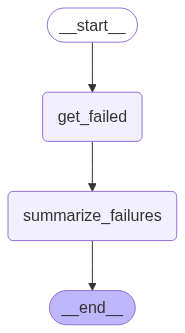

In [19]:
# Failure analysis Sub Graph

class FailureAnalysisInputState(TypedDict):
    cleaned_logs: List[Log]
    failures: List[Log]
    fail_summary: str
    processed_logs: List[str]

class FailureAnalysisOutputState(TypedDict):
    fail_summary: str
    processed_logs: List[str]


#Node
def get_failed(state):
    """ get logs that contain failures """
    cleaned_logs = state['cleaned_logs']
    failures = [log for log in cleaned_logs if log.get('grade') == 0]
    return {'failures': failures}

def summarize_failures(state):
    """ summarize failures """
    failures = state['failures']
    fail_summary = f"Total Failures: {len(failures)}\n"
    fail_summary += "\n".join([f"ID: {log['id']}, Question: {log['question']}" for log in failures])
    return {'fail_summary': fail_summary, "processed_logs": [f"failure Summary --> {log['id']}" for log in failures]}

# Graph building

failure_analysis_sub_graph_builder = StateGraph(FailureAnalysisInputState, input_schema=FailureAnalysisInputState, output_schema=FailureAnalysisOutputState)
failure_analysis_sub_graph_builder.add_node('get_failed', get_failed)
failure_analysis_sub_graph_builder.add_node('summarize_failures', summarize_failures)
failure_analysis_sub_graph_builder.add_edge(START, 'get_failed')
failure_analysis_sub_graph_builder.add_edge('get_failed', 'summarize_failures')
failure_analysis_sub_graph_builder.add_edge('summarize_failures', END)

failure_analysis_sub_graph = failure_analysis_sub_graph_builder.compile()
display(Image(failure_analysis_sub_graph.get_graph().draw_mermaid_png())) # Make sure you have the proxy Enabled

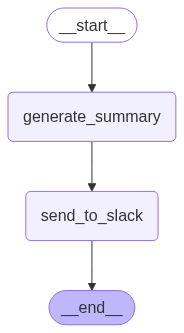

In [20]:
# Summarization Sub Graph

class SummarizationInputState(TypedDict):
    cleaned_logs: List[Log]
    summary: str
    report: str
    processed_logs: List[str]

class SummarizationOutputState(TypedDict):
    report: str
    processed_logs: List[str]


#Node
def generate_summary(state):
    """ get summary form the logs """
    cleaned_logs = state['cleaned_logs']
    summary = "this is a summary of the logs:\n"
    return {'summary': summary, 'processed_logs': [f"Sumamry on logs --> {log['id']}" for log in cleaned_logs]}

def send_to_slack(state):
    """ send summary to slack """
    summary = state['summary']
    report = " Based on the Summary this report is generated:\n"
    return {'report': report}

# Graph building

summary_sub_graph_builder = StateGraph(SummarizationInputState, input_schema=SummarizationInputState, output_schema=SummarizationOutputState)
summary_sub_graph_builder.add_node('generate_summary', generate_summary)
summary_sub_graph_builder.add_node('send_to_slack', send_to_slack)
summary_sub_graph_builder.add_edge(START, 'generate_summary')
summary_sub_graph_builder.add_edge('generate_summary', 'send_to_slack')
summary_sub_graph_builder.add_edge('send_to_slack', END)

summary_sub_graph = summary_sub_graph_builder.compile()
display(Image(summary_sub_graph.get_graph().draw_mermaid_png())) # Make sure you have the proxy Enabled

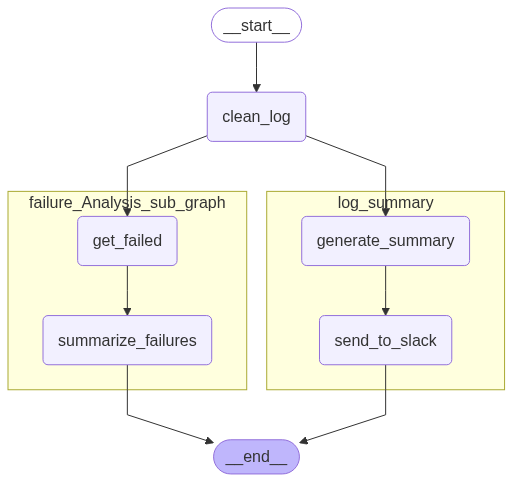

In [21]:
# Adding Sub graphs to Parent graph

class ParentGraphState(TypedDict):
    raw_logs: List[Log]
    cleaned_logs: List[Log]
    fail_summary: str # This will only be generated in FA Sub graph
    report: str # This will be only generated in Summary Sub graph
    processed_logs: Annotated[List[str], add] # This will be updated in both the Sub Graphs

# Node
def clean_logs(state):
    raw_logs = state["raw_logs"]
    return {"cleaned_logs": raw_logs}

parent_graph_builder = StateGraph(ParentGraphState)
parent_graph_builder.add_node('clean_log', clean_logs)
parent_graph_builder.add_node("failure_Analysis_sub_graph", failure_analysis_sub_graph)
parent_graph_builder.add_node("log_summary", summary_sub_graph)

parent_graph_builder.add_edge(START, "clean_log")
parent_graph_builder.add_edge("clean_log", "failure_Analysis_sub_graph")
parent_graph_builder.add_edge("clean_log", "log_summary")
parent_graph_builder.add_edge(["failure_Analysis_sub_graph", "log_summary"], END)

graph = parent_graph_builder.compile()
display(Image(graph.get_graph(xray=1).draw_mermaid_png())) # Make sure you have the mobileDox

In [ ]:
# Dummy logs

logs= [
    Log(
    id= '1',
    question= "How Can I import ChatOllama ?",
    answer= "to import oLlama, do blah blah blah"),
    Log(
    id= '2',
    question= "How Can I use Vector Store?",
    grade = 0,
    answer= "ERROR:to import oLlama, do blah blah blah Ashu vector Store")
]
graph.invoke({"raw_logs": logs})

{'raw_logs': [{'id': '1',
   'question': 'How Can I import ChatOllama ?',
   'answer': 'to import oLlama, do blah blah blah'},
  {'id': '2',
   'question': 'How Can I use Vector Store?',
   'grade': 0,
   'answer': 'to import oLlama, do blah blah blah Ashu vector Store'}],
 'cleaned_logs': [{'id': '1',
   'question': 'How Can I import ChatOllama ?',
   'answer': 'to import oLlama, do blah blah blah'},
  {'id': '2',
   'question': 'How Can I use Vector Store?',
   'grade': 0,
   'answer': 'to import oLlama, do blah blah blah Ashu vector Store'}],
 'fail_summary': 'Total Failures: 1\nID: 2, Question: How Can I use Vector Store?',
 'report': ' Based on the Summary this report is generated:\n',
 'processed_logs': ['failure Summary --> 2',
  'Sumamry on logs --> 1',
  'Sumamry on logs --> 2']}